In [1]:
from __future__ import division 

import gym
import numpy as np
import random
import tensorflow as tf 
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
import sys
%matplotlib inline

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ..., 
       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255,

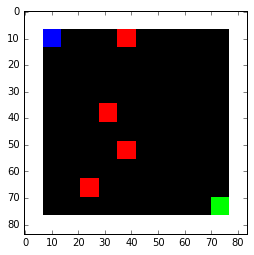

In [11]:
from gridworld_v03_1 import gameEnv
env = gameEnv(partial=False, size=10)
env.renderEnv()

In [12]:
class Qnetwork():
    def __init__(self, h_size, name = "main"):
        self.h_size = h_size
        self.net_name = name
        
        self.build_network()
        
    def build_network (self): #// h_size is the number of activation of conv4 
        #The network recieves a frame from the game, flattened into an array.
      
    #    self.scalarInput = tf.placeholder(shape=[None,84*84*3], dtype=tf.float32)
    #    self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        
        with tf.variable_scope(self.net_name):
            # Input(return value of env.reset) dimension
            # self.dimX = env.?

            self.dimX = len(env.objects) * 2
            self.dimY = env.actions

            # Dimensions of each layer 
            self.nInputLayer = self.dimX
            self.nHidden1 = h_size
            self.nHidden2 = (int)(h_size)
            self.nHidden3 = (int)(h_size)
            self.nOutputLayer = self.dimY

            self.input = tf.placeholder(shape=[None, self.dimX], dtype=tf.float32)
            self.output = tf.placeholder(shape=[None, self.dimY], dtype=tf.float32)

            # Weights of each layer
            self.W = {
                'W1': self.init_weight("W1", [self.nInputLayer, self.nHidden1]),
                'W2': self.init_weight("W2", [self.nHidden1, self.nHidden2]),
                'W3': self.init_weight("W3", [self.nHidden2, self.nHidden3]),
                'W4': self.init_weight("W4", [self.nHidden3, self.nOutputLayer])
            }

            # Bias of each layer
            self.b = {
                'b1': self.init_bias(self.nHidden1),
                'b2': self.init_bias(self.nHidden2),
                'b3': self.init_bias(self.nHidden3),
                'b4': self.init_bias(self.nOutputLayer)
            }

            # If we need,
            self.dropProb = 0.0


            self.hidden1 = tf.nn.relu(tf.add(tf.matmul(self.input, self.W['W1']), self.b['b1']))
            # self.hidden1 = tf.nn.dropout(self.hidden1, self.dropProb)

            self.hidden2 = tf.nn.relu(tf.add(tf.matmul(self.hidden1, self.W['W2']), self.b['b2']))
            # self.hidden2 = tf.nn.dropout(self.hidden2, self.dropProb)

            self.hidden3 = tf.nn.relu(tf.add(tf.matmul(self.hidden2, self.W['W3']), self.b['b3']))
            # self.hidden3 = tf.nn.dropout(self.hidden3, self.dropProb)

            self.output = tf.add(tf.matmul(self.hidden3, self.W['W4']), self.b['b4'])

            """
            self.conv1 = slim.conv2d(inputs=self.imageIn,
                                     num_outputs=32,
                                     kernel_size=[8,8],
                                     stride=[4,4],
                                     padding='VALID', 
                                     biases_initializer = None)

            self.conv2 = slim.conv2d(inputs=self.conv1,
                                     num_outputs=64,
                                     kernel_size=[4,4],
                                     stride=[2,2],
                                     padding='VALID',
                                     biases_initializer = None)

            self.conv3 = slim.conv2d(inputs=self.conv2,
                                     num_outputs=64,
                                     kernel_size=[3,3],
                                     stride=[1,1],
                                     padding='VALID',
                                     biases_initializer = None)

            self.conv4 = slim.conv2d(inputs=self.conv3,
                                     num_outputs=h_size,
                                     kernel_size=[7,7],
                                     stride=[1,1],
                                     padding='VALID',
                                     biases_initializer = None)
             """

            #We take the output from the final convolutional layer and split it into separated terms: advantage & value
            # I think the input dimension of our env is 1-dim 
            self.streamAC, self.streamVC = tf.split(self.output, 2, 1)
            self.streamA = slim.flatten(self.streamAC)
            self.streamV = slim.flatten(self.streamVC)

            xavier_init = tf.contrib.layers.xavier_initializer()

            self.AW = tf.Variable(xavier_init([self.dimY//2, env.actions]))
            self.VM = tf.Variable(xavier_init([self.dimY//2, 1]))

            self.Advantage = tf.matmul(self.streamA, self.AW)
            self.Value = tf.matmul(self.streamV, self.VM)

            #Then combine to obtain the final Q-value //why substract mean from Advantage?
            self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage,axis=1, keep_dims=True))
            self.predict = tf.argmax(self.Qout, 1)

            #Obtain the loss by taking the sum of squares difference between the target and predicted Q values
            self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32) #// env.actions is probably number of actions

            self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)

            self.td_error = tf.square(self.targetQ - self.Q)
            self.loss = tf.reduce_mean(self.td_error)

            self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
            self.updateModel = self.trainer.minimize(self.loss)    
            
    def init_weight(self, name, shape):
        return tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

    def init_bias(self, n):
        return tf.Variable(tf.random_normal([n]))

In [13]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)#// remove the necesary entries to make place for new experience
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5]) # buffer is experience tuple (size 4) plus "done" signal

In [14]:
def processState(states):
    return np.reshape(states,[84*84*3])

In [15]:
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    
    for idx,var in enumerate(tfVars[0:total_vars//2]): #// select the first half of the variables (the one that belong to the action choosing net) 
        op_holder.append(
            tfVars[idx+total_vars//2].assign(
                (var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))#// basically take values from the primary net and modify then slithly with values from the second net, then return then for later use of model update 
    
    return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)  

In [16]:
def get_copy_var_ops(*, dest_scope_name="target", src_scope_name="main"):
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))
        
    return op_holder

In [17]:
#Set all the training parameters
batch_size = 64 #Number of experiences to use for each training step
update_freq = 10 #Frequency of a train step

y = .99 #Discount factor on the target Q-values

startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
#anneling_steps = 10000. #Number of training steps to decrease the explorarion parameter e 
anneling_steps = 5000

#num_episodes = 3*10000 #Number of episodes of the game environmet on which to train the network
num_episodes = 5000
#pre_train_steps = 10000 #Number of random action steps before training begins
pre_train_steps = 5000

#max_epLength = 100 #Maximun allowed length of a game episode
max_epLength = 100

load_model = False #Wheter to load a saved model
path = "./log2" #Directory for checkpoints
#log_path = "./dqn_logs/logs" #Directory for logs

h_size = 512 #Number of activations of final conv layer

tau = 0.001 #Rate of update of target network values onto the primary network

#f = open(log_path,'w')

In [18]:
tf.reset_default_graph()

#Network instances
mainQN = Qnetwork(h_size, name="main")
targetQN = Qnetwork(h_size, name="target")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease
e = startE
stepDrop = (startE - endE)/anneling_steps

#Create lists to contain total reward and steps per episode
jList = []
rList = []
total_steps = 0

#Create path for checkpoints
if not os.path.exists(path):
    os.makedirs(path)

In [19]:
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        if i%100 == 0:
            print("\n=====" + "Episode " + str(i) + "start =====" )
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        # s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.input:[s]})[0]
            s1,r,d = env.step(a)
            #print(s1, r, d)
            #s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.input:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.input:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.input:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")


=====Episode 0start =====
Saved Model
391 -5.2 1
775 -5.5 1
1158 -3.0 1
1454 -2.4 1
1915 -5.5 1
2348 -5.4 1
2700 -3.5 1
2948 -2.6 1
3404 -5.0 1
3774 -4.9 1

=====Episode 100start =====
4271 -4.2 1
4737 -7.0 1
5195 -4.9 0.9649000000000082
5452 -4.0 0.918640000000019
5696 -3.3 0.8747200000000293
6054 -5.6 0.8102800000000443
6557 -6.7 0.7197400000000654
6943 -8.2 0.6502600000000817
7661 -20.9 0.5210200000001118
8206 -25.2 0.42292000000011093

=====Episode 200start =====
8862 -31.6 0.3048400000001021
9491 -31.0 0.1916200000000936
10313 -0.9 0.09982000000008867
10860 -0.7 0.09982000000008867
11646 -2.8 0.09982000000008867
12086 -1.2 0.09982000000008867
12857 -0.7 0.09982000000008867
13416 -0.7 0.09982000000008867
14284 -0.5 0.09982000000008867
14753 -0.8 0.09982000000008867

=====Episode 300start =====
15549 -0.5 0.09982000000008867
16282 -0.5 0.09982000000008867
16977 -9.2 0.09982000000008867
17610 -1.1 0.09982000000008867
18236 -8.0 0.09982000000008867
19081 -1.7 0.09982000000008867
1973

163464 -1.1 0.09982000000008867
163875 0.3 0.09982000000008867
164435 -1.6 0.09982000000008867
164783 0.6 0.09982000000008867
165233 -0.3 0.09982000000008867
165700 -0.5 0.09982000000008867

=====Episode 2500start =====
166201 -0.3 0.09982000000008867
166648 0.2 0.09982000000008867
167096 -0.2 0.09982000000008867
167618 -0.6 0.09982000000008867
168152 -0.3 0.09982000000008867
168624 -0.9 0.09982000000008867
169193 -1.6 0.09982000000008867
169438 -0.3 0.09982000000008867
170072 -1.2 0.09982000000008867
170355 0.7 0.09982000000008867

=====Episode 2600start =====
170875 -0.2 0.09982000000008867
171352 -0.3 0.09982000000008867
171836 -0.6 0.09982000000008867
172190 0.3 0.09982000000008867
172679 -0.9 0.09982000000008867
173046 -0.3 0.09982000000008867
173562 -0.5 0.09982000000008867
173832 -0.1 0.09982000000008867
174222 -0.4 0.09982000000008867
174665 -0.4 0.09982000000008867

=====Episode 2700start =====
175270 -0.4 0.09982000000008867
175639 -0.4 0.09982000000008867
175955 -0.2 0.09982

240385 -0.1 0.09982000000008867
240551 0.5 0.09982000000008867
240882 0.7 0.09982000000008867
241156 0.4 0.09982000000008867
241467 0.8 0.09982000000008867
241823 0.1 0.09982000000008867
242037 0.7 0.09982000000008867
242295 0.2 0.09982000000008867

=====Episode 4900start =====
242365 1.0 0.09982000000008867
242715 0.3 0.09982000000008867
242973 0.7 0.09982000000008867
243261 0.2 0.09982000000008867
243371 1.0 0.09982000000008867
243736 0.5 0.09982000000008867
243844 1.0 0.09982000000008867
244093 0.1 0.09982000000008867
244286 0.9 0.09982000000008867
244540 0.6 0.09982000000008867
Percent of succesful episodes: -1.261%


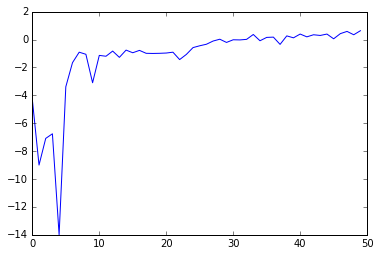

In [20]:
rMat = np.resize(np.array(rList), [len(rList)//100,100])
rMean = np.average(rMat, 1)
plt.plot(rMean)

------------------------------------

## Testing the network performance

This first piece of code aims to make a step by step walkthrough the game to see what actions is taken
For some reason the actor is performing a single action. Need to debug.

In [13]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

In [14]:
sess = tf.InteractiveSession()

In [15]:
ckpt = tf.train.get_checkpoint_state(path)
saver.restore(sess, ckpt.model_checkpoint_path)    

INFO:tensorflow:Restoring parameters from ./dqn_logs/model-29999.cptk


[2017-06-05 16:39:39,215] Restoring parameters from ./dqn_logs/model-29999.cptk


In [16]:
#Reset environment and get the first new observation
s = env.reset()
#s = processState(s)
d = False
rAll_t = 0
j_t = 0        

Action: 1
Reward: 0 , Done: False


TypeError: Invalid dimensions for image data

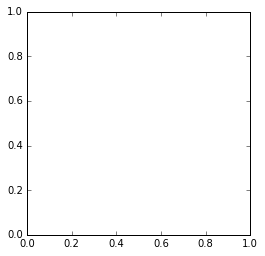

In [17]:
#Choose an action by greedily picking from the Q-net
a = sess.run(mainQN.predict, feed_dict={mainQN.input:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns

print ("Action: %d" % a)
s1, r, d = env.step(a)
print ("Reward: %d , Done: %s" % (r, d))
plt.imshow(s1, interpolation = "nearest")
#s1 = processState(s1)#// flatten the return frame
total_steps_t += 1
                        
rAll_t += r
s = s1


if d == True:
    print("End of training episode")
    jList_t.append(j_t)
    rList_t.append(rAll_t)
            
    if len(rList_t) % 10 == 0:
        accumR = np.mean(rList_t[-10:])
        log = str(total_steps_t) +"\t"+ str(accumR) 
        print(log)            

In [18]:
sess.close()

Test the actor in an automatic way. The issue is the same, the actor chooses the same action constantly

In [12]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

# Test setting parameters
load_model = True
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
with tf.Session() as sess:
    
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    for i in range(num_test_episodes):
        
        #Reset environment and get the first new observation
        s = env.reset()
        #s = processState(s)
        d = False
        rAll_t = 0
        j_t = 0
        
        #Q-Network
        while j_t < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trail
            j_t+=1
            
            #Choose an action by greedily picking from the Q-net
            a = sess.run(mainQN.predict, feed_dict={mainQN.input:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns
                
            s1, r, d = env.step(a)
           #s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                        
              
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
            #f.write(log)
                
    
final_log = "Percent of sucessful episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

Loading Model...
INFO:tensorflow:Restoring parameters from ./log2/model-49999.cptk


[2017-06-06 01:59:34,974] Restoring parameters from ./log2/model-49999.cptk


527	0.5
1147	0.4
1674	0.5
2294	0.4
2821	0.5
3441	0.4
3968	0.5
4588	0.4
5115	0.5
5735	0.4
6262	0.5
6882	0.4
7409	0.5
8029	0.4
8556	0.5
9176	0.4
9703	0.5
10323	0.4
10850	0.5
11470	0.4
11997	0.5
12617	0.4
13144	0.5
13764	0.4
14291	0.5
14911	0.4
15438	0.5
16058	0.4
16585	0.5
17205	0.4
17732	0.5
18352	0.4
18879	0.5
19499	0.4
20026	0.5
20646	0.4
21173	0.5
21793	0.4
22320	0.5
22940	0.4
23467	0.5
24087	0.4
24614	0.5
25234	0.4
25761	0.5
26381	0.4
26908	0.5
27528	0.4
28055	0.5
28675	0.4
29202	0.5
29822	0.4
30349	0.5
30969	0.4
31496	0.5
32116	0.4
32643	0.5
33263	0.4
33790	0.5
34410	0.4
34937	0.5
35557	0.4
36084	0.5
36704	0.4
37231	0.5
37851	0.4
38378	0.5
38998	0.4
39525	0.5
40145	0.4
40672	0.5
41292	0.4
41819	0.5
42439	0.4
42966	0.5
43586	0.4
44113	0.5
44733	0.4
45260	0.5
45880	0.4
46407	0.5
47027	0.4
47554	0.5
48174	0.4
48701	0.5
49321	0.4
49848	0.5
50468	0.4
50995	0.5
51615	0.4
52142	0.5
52762	0.4
53289	0.5
53909	0.4
54436	0.5
55056	0.4
55583	0.5
56203	0.4
56730	0.5
57350	0.4
57877	0.5
58497	0.

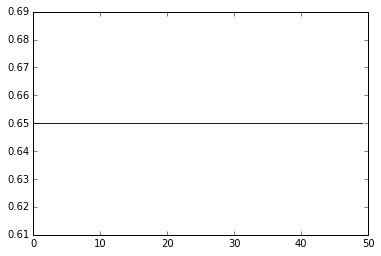

In [20]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)

---------------------------------------------

## Test Random Actor

In [35]:
# Test setting parameters for random actor
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

_,_ = env.checkGoal()

with tf.Session() as sess:
    sess.run(init)
        
    for i in range(num_test_episodes):
        
        d = False
        rAll_t = 0
        j_t = 0
        
        while j_t < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trail
            j_t += 1
            
            a = np.random.randint(0,4)
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                      
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
                           
    
final_log = "Percent of sucessful test episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

62	-0.6
140	-1.0
248	-1.0
367	-0.8
427	-0.8
564	-0.6
607	-0.6
730	-0.9
806	-0.8
891	-0.6
1013	-1.0
1129	-0.8
1209	-0.4
1307	-0.6
1406	-0.9
1508	-0.6
1562	-1.0
1608	-1.0
1751	-0.8
1836	-0.8
1912	-0.6
2003	-0.6
2101	-0.8
2194	-1.0
2268	-1.0
2314	-0.8
2394	-0.6
2477	-1.0
2575	-1.0
2671	-1.0
2753	-0.8
2828	-0.8
2936	-0.8
3003	-1.0
3082	-0.6
3173	-0.6
3318	-0.6
3429	-0.8
3575	-0.5
3740	-0.4
3828	-0.2
3975	-0.8
4082	-1.0
4133	-0.8
4202	-0.8
4267	-0.6
4386	-0.8
4505	-0.4
4626	-0.4
4693	-1.0
4745	-0.8
4792	-0.8
4860	-0.6
4974	-0.9
5031	-0.6
5066	-0.8
5207	-0.8
5313	-0.6
5410	-0.8
5513	-1.0
5582	-0.8
5683	-0.6
5811	-1.0
5865	-0.8
5954	-0.8
6006	-0.2
6121	-1.0
6246	-0.8
6300	-0.8
6394	-0.6
6516	-0.7
6616	-0.8
6679	-0.4
6758	-0.6
6842	-0.4
6887	-0.4
6955	-0.8
7006	-0.6
7111	-0.8
7225	-0.4
7268	-1.0
7397	-0.8
7455	-0.6
7529	-1.0
7564	-0.6
7643	-0.8
7731	-0.8
7886	-1.0
7990	-0.6
8073	-0.8
8120	-0.6
8186	-1.0
8213	-0.8
8283	-0.4
8357	-0.8
8417	-0.8
8510	-1.0
8649	-1.0
8715	-0.4
8798	-0.8
8884	-0.6
8

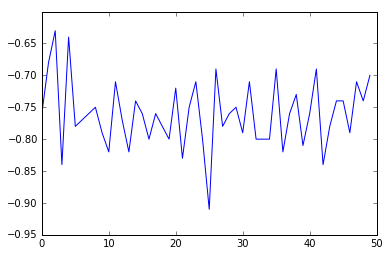

In [34]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)